# PVe3 enhancer processing

Another project we have now, well an expansion of the enhancer AAV. Like the BEC enhancer, the new enhancers we are testing are for specific cell-types, this time neurons. I did add a folder called "PVe3 enhancer" with the images. There will be 2 files per slide. Files ending in "mCH" is the signal from virus and files ending in "cy5" are the immunostaining ("ground truth)

There are 3 folders inside, each a different condition (mouse). Each folder has files from the virus signal (ending name "mCH") and immunostaining signal ("ground truth" ending in "cy5"). The detection in more like the U01, but the analysis (comparison) like our BEC enhancer . Im not sure how fast this will take and I know you have a lot in your plate, so instead of doing all the images, focus only in few images.

* From 1yo 5xFAD: check files "12" and "16"
* From old C57: check files "20" and "24"    **virus signal is weak and lots of small background noise in the mCH channel
* From young C57: check files "2" and "6"

The original paper did quantify the specificity and sensitivity in single layer of the cortex only. I think it will be easier to focus on the whole cortex rather than separating layers  (until Dr. Xu says other wise or wants to get the whole brain)

https://pmc.ncbi.nlm.nih.gov/articles/PMC11291062/


## Imports and functions

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import SimpleITK as sitk
sitk.ProcessObject_SetGlobalWarningDisplay(False)

In [36]:
### Functions for IO operations
def read_tif(filepath):
    """
    Read tiff files using SimpleITK
    
    Args:
        filepath: str, path to tiff file
        
    Returns:
        image: np.ndarray, tiff image
    """
    image = sitk.ReadImage(filepath)
    image = sitk.GetArrayFromImage(image)
    
    print(f"Reading {filepath}")
    print(f"Image shape: {image.shape}")
    print(f"Image dtype: {image.dtype}")
    print(f"Image min: {image.min()}")
    print(f"Image max: {image.max()}")
    print(f"Image mean: {image.mean()}\n")
    return image


def auto_contrast(data: np.ndarray, alpha: float = None, beta: float = None) -> np.ndarray:
    """
    Preprocess tiff files to automatically adjust brightness and contrast.
    https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape
    """
    if not alpha:
        alpha = np.iinfo(data.dtype).max / (np.max(data) - np.min(data))
    if not beta:
        beta = -np.min(data) * alpha
    img = cv2.convertScaleAbs(data.copy(), alpha=alpha, beta=beta)
    return img


def gamma_correction(image: np.ndarray, gamma: float=2.0, min_value=None, max_value=None) -> np.ndarray:
    """
    Apply gamma correction to the image.
    
    Args:
        image: np.ndarray, input image
        gamma: float, gamma value
        
    Returns:
        image_enhanced: np.ndarray, gamma corrected image
    """
    if min_value is not None:
        image = image.copy()
        image[image < min_value] = 0
    if max_value is None:
        max_value = image.max()
    else:
        image = image.copy()
        image[image > max_value] = max_value
    # Normalize the image to the range [0, 1]
    image_normalized = image / max_value
    # Apply the exponential transformation
    image_enhanced = np.power(image_normalized, gamma)
    # Rescale the image back to the original intensity range
    image_enhanced = image_enhanced * max_value
    return image_enhanced


def save_figure(image, filename, contours=None):
    """
    Save figure to disk.
    
    Args:
        image: np.ndarray, input image
        filename: str, path to save the image
        contours: np.ndarray, contours to overlay on the image
    """
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap='gray')
    if contours is not None:
        plt.contour(contours, colors='red', linewidths=0.15, alpha=0.35)
    plt.axis('off')
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"Saved figure to {filename}")
    
    
def show(image: np.ndarray, image2: np.ndarray = None,
         suptitle: str = "", title: str = "", title2: str = "", 
         cmap: str = 'gray',
         xlim: tuple[int, int] = None, ylim: tuple[int, int] = None,
         xlim2: tuple[int, int] = None, ylim2: tuple[int, int] = None,
         axis: bool = True,
         figsize: tuple[int, int] = (10, 6)):
    """
    Display the image.
    
    Args:
        image: np.ndarray, input image
        title: str, title of the image
    """
    f = plt.figure(figsize=figsize)
    
    # Add a big title
    if suptitle is not "":
        f.suptitle(suptitle, fontsize=16)
    
    # If there are two images, display them side by side
    if image2 is not None:
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        plt.axis(axis)
        plt.subplot(1, 2, 2)
        plt.imshow(image2, cmap=cmap)
        plt.title(title2)
        if xlim2 is not None:
            plt.xlim(xlim2)
        if ylim2 is not None:
            plt.ylim(ylim2)
        plt.axis(axis)
        
    # If there is only one image, display it
    else:
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        plt.axis(axis)
    plt.show()
    f.clear()
    plt.close(f)

<>:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_262378/1491075107.py:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if suptitle is not "":


## Load data

In [37]:
# Filepaths for data
#   Virus signal ends with mCH
#   Ground truth signal ends with cy5
virus_filepath = "data/1yo 5xFAD_M47/Eric_hipp-GABAe-PVe3_M44_M47_M50_PV-Cy5_10x_DAPI, FITC, mCH, cy5_12_mCH.tif"
gt_filepath = "data/1yo 5xFAD_M47/Eric_hipp-GABAe-PVe3_M44_M47_M50_PV-Cy5_10x_DAPI, FITC, mCH, cy5_12_cy5.tif"

# Name of the sample
sample_name = "1yo 5xFAD_M47 - file 12"

In [41]:
print("Virus")
virus_img = read_tif(virus_filepath)
print("Ground truth")
gt_img = read_tif(gt_filepath)

Virus
Reading data/1yo 5xFAD_M47/Eric_hipp-GABAe-PVe3_M44_M47_M50_PV-Cy5_10x_DAPI, FITC, mCH, cy5_12_mCH.tif
Image shape: (9238, 6676)
Image dtype: uint16
Image min: 0
Image max: 65535
Image mean: 732.3172883682697

Ground truth
Reading data/1yo 5xFAD_M47/Eric_hipp-GABAe-PVe3_M44_M47_M50_PV-Cy5_10x_DAPI, FITC, mCH, cy5_12_cy5.tif
Image shape: (9238, 6676)
Image dtype: uint16


TIFFReadDirectory: Warning, Unknown field with tag 33560 (0x8318) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33560 (0x8318) encountered.


Image min: 0
Image max: 12765
Image mean: 386.1190746410319



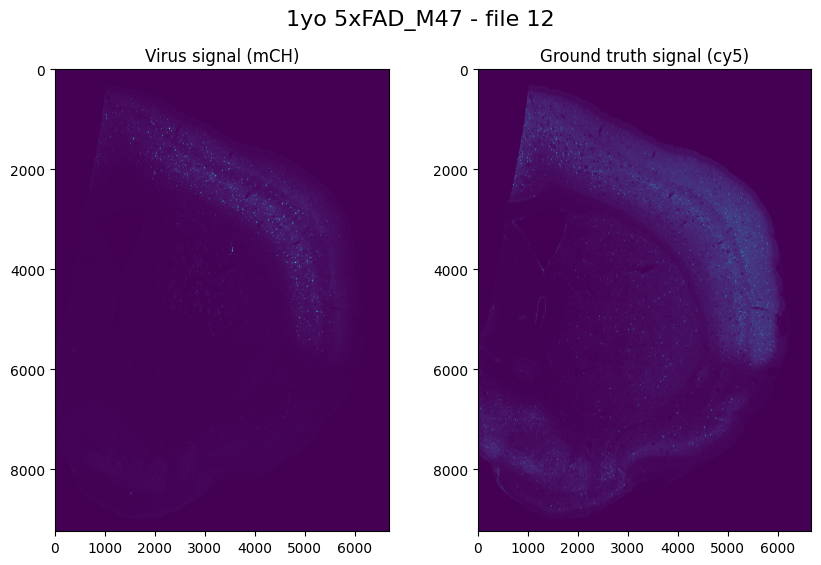

In [39]:
show(virus_img, gt_img, suptitle=sample_name, 
     title="Virus signal (mCH)", title2="Ground truth signal (cy5)", 
     cmap='viridis')